**Import Libraries**

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Import Data**

In [ ]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [ ]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))


In [ ]:
ts = data.traffic_volume['2017-09-29':'2018-09-29']

In [ ]:
ts.head()

date_time
2017-09-29 00:00:00    751
2017-09-29 01:00:00    432
2017-09-29 02:00:00    310
2017-09-29 03:00:00    348
2017-09-29 04:00:00    860
Name: traffic_volume, dtype: int64

##Train/test Split

In [ ]:
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

**Stationnarity**

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(168).mean()
    rolstd = timeseries.rolling(168).std()

    #Plot rolling statistics:
    plt.figure(figsize=(30,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

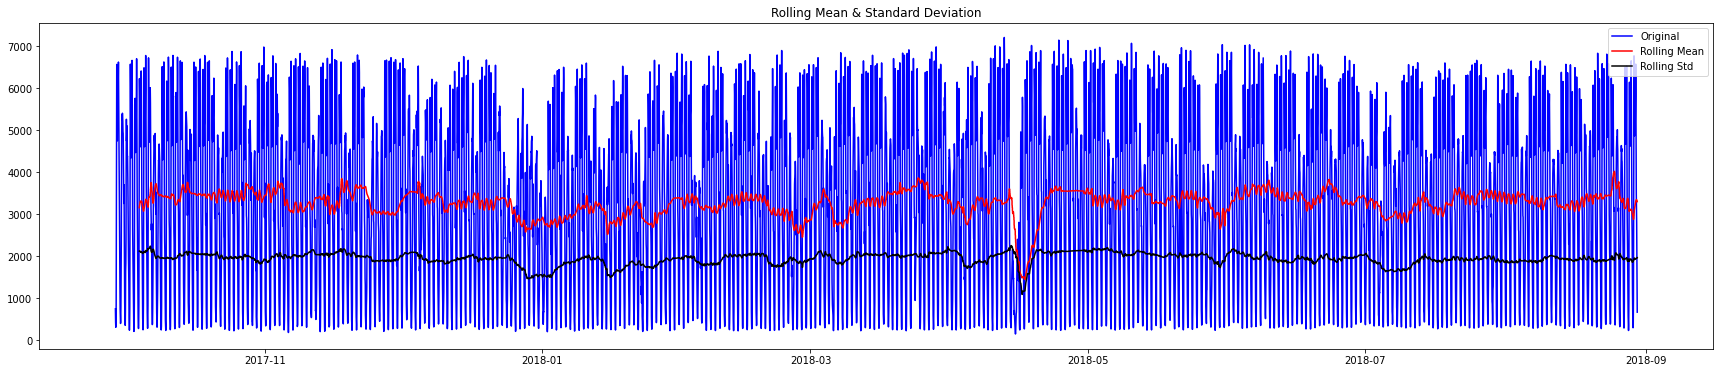

Results of Dickey-Fuller Test:
Test Statistic                -1.548486e+01
p-value                        2.528511e-28
#Lags Used                     3.300000e+01
Number of Observations Used    9.624000e+03
Critical Value (1%)           -3.431030e+00
Critical Value (5%)           -2.861840e+00
Critical Value (10%)          -2.566930e+00
dtype: float64


In [ ]:
test_stationarity(ts_train)

**Building a model**

In [ ]:
# ACF and PACF plots
lag = 168
lag_pacf = pacf(ts_train, nlags=lag, method='ols')
lag_acf = acf(ts_train, nlags=lag)

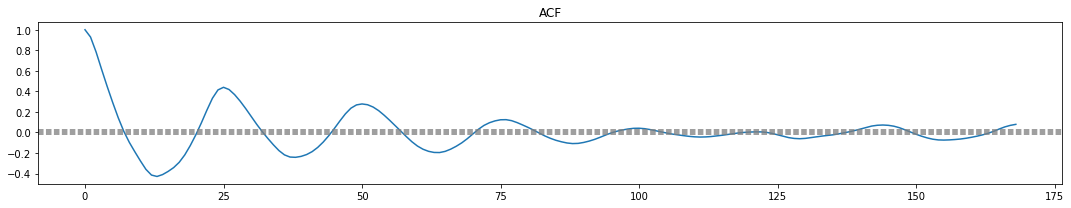

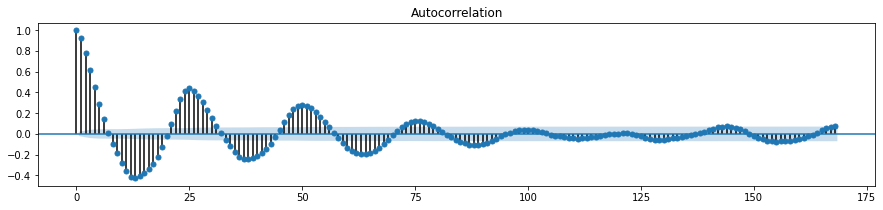

In [ ]:
#Plot ACF auto corrletion function 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train, ax=plt.gca(),lags=lag)
plt.show()

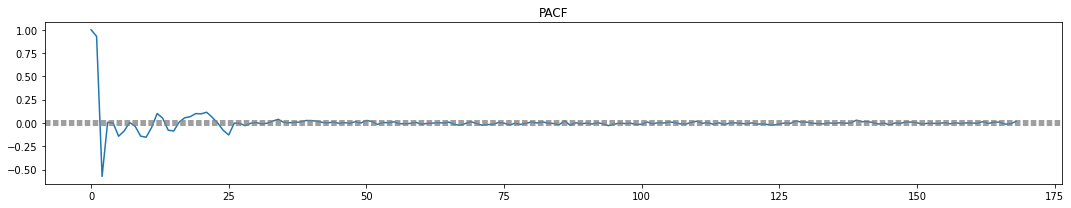

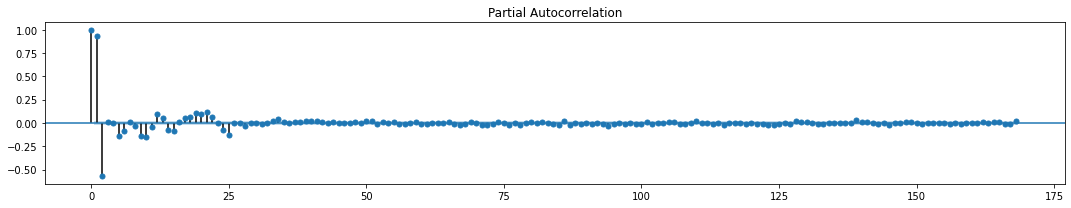

In [ ]:
#Plot PACF partial auto corrletion function
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [ ]:
p=1
q=7
d=0

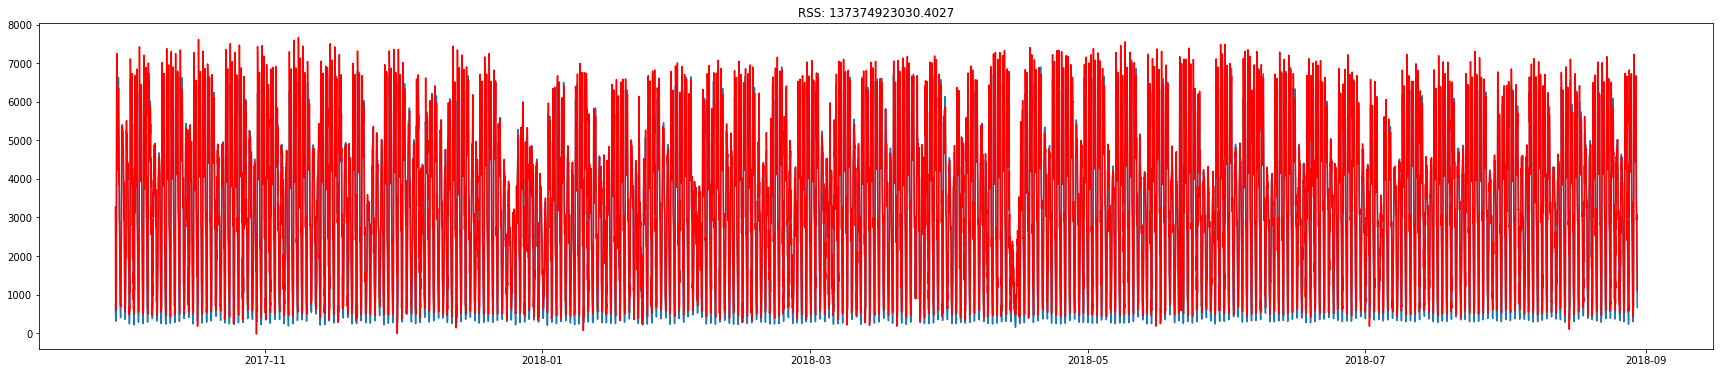

In [ ]:
# ARIMA auto autoregressive integrated moving average
model = ARIMA(ts_train, order=(p, d, q))  
results_ARIMA = model.fit(disp=1)
plt.figure(figsize=(30,6))
plt.plot(ts_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

In [ ]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                 9658
Model:                     ARMA(1, 7)   Log Likelihood              -75380.274
Method:                       css-mle   S.D. of innovations            593.399
Date:                Thu, 29 Apr 2021   AIC                         150780.548
Time:                        17:16:52   BIC                         150852.303
Sample:                             0   HQIC                        150804.878
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3271.8814     54.763     59.747      0.000    3164.548    3379.214
ar.L1.traffic_volume     0.3852      0.044      8.853      0.000       0.300       0.470
ma.L1.traffic_volume     1.0799      0.042     25.524      0.000       0.997       1.163
ma.L2.traffic_volume     1.0354      0.063     16.508      0.000       0.913       1.158
ma.L3.traffic_volume     0.8270      0.071     11.582      0.000       0.687       0.967
ma.L4.traffic_volume     0.6510      0.066      9.922      0.000       0.522       0.780
ma.L5.traffic_volume     0.5081      0.051     10.003      0.000       0.409       0.608
ma.L6.traffic_volume     0.3355      0.033     10.254      0.000       0.271       0.400
ma.L7.traffic_volume     0.1409      0.017      8.510      0.000       0.108       0.173
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5961           +0.0000j            2.5961            0.0000
MA.1            0.7582           -1.0095j            1.2625           -0.1475
MA.2            0.7582           +1.0095j            1.2625            0.1475
MA.3           -0.2068           -1.2609j            1.2778           -0.2759
MA.4           -0.2068           +1.2609j            1.2778            0.2759
MA.5           -1.0299           -0.9243j            1.3839           -0.3836
MA.6           -1.0299           +0.9243j            1.3839            0.3836
MA.7           -1.4240           -0.0000j            1.4240           -0.5000
-----------------------------------------------------------------------------
"""

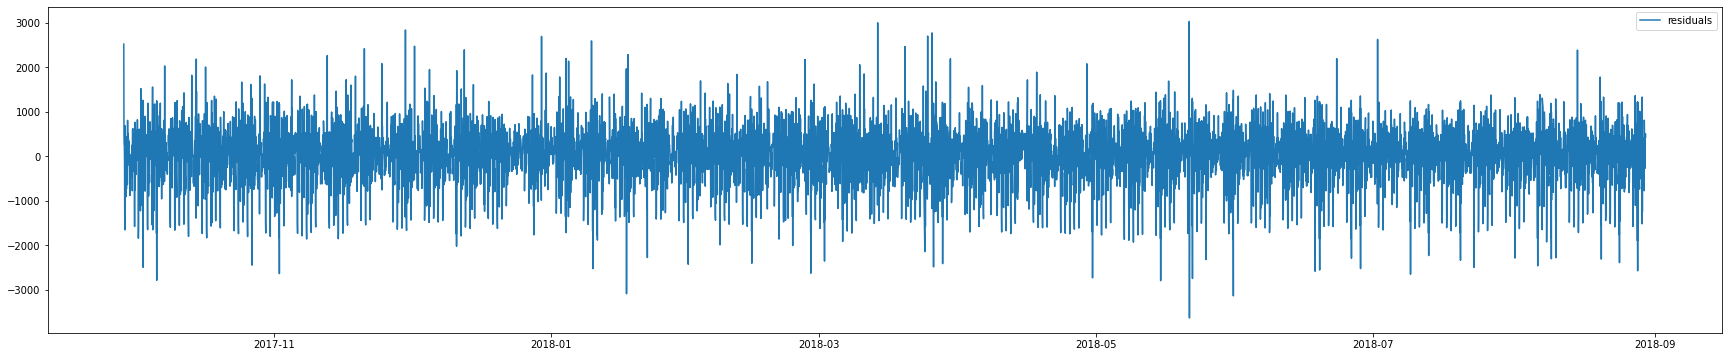

In [ ]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

## Test ARIMA on testset

In [ ]:
def StartARIMAForecasting(Actual, p, d, q):
	model = ARIMA(Actual, order=(p, d, q))
	model_fit = model.fit(disp=0)
	prediction = model_fit.forecast()[0]
	return prediction

In [ ]:
#new arrays to store actual and predictions
Actual = [x for x in ts_train]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test)):
	ActualValue =  ts_test[timepoint]
	#forcast value
	Prediction = StartARIMAForecasting(Actual, 3,1,0)    
	print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
	#add it in the list
	Predictions.append(Prediction)
	Actual.append(ActualValue)  
 
predictions=pd.DataFrame(Predictions).set_index(ts_test.index)

Actual=456.000000, Predicted=451.471059
Actual=326.000000, Predicted=457.902952
Actual=388.000000, Predicted=327.377505
Actual=388.000000, Predicted=453.416708
Actual=1008.000000, Predicted=397.433599
Actual=1008.000000, Predicted=1354.244778
Actual=3070.000000, Predicted=969.015761
Actual=5886.000000, Predicted=4178.445406
Actual=6466.000000, Predicted=7359.556151
Actual=6466.000000, Predicted=6406.672334
Actual=5995.000000, Predicted=6141.210261
Actual=5467.000000, Predicted=5667.862525
Actual=4911.000000, Predicted=5196.665892
Actual=5095.000000, Predicted=4676.585235
Actual=5308.000000, Predicted=5289.331322
Actual=5213.000000, Predicted=5474.864443
Actual=5680.000000, Predicted=5126.858898
Actual=6238.000000, Predicted=5930.203270
Actual=6453.000000, Predicted=6536.012130
Actual=5775.000000, Predicted=6492.472842
Actual=4531.000000, Predicted=5318.652642
Actual=3884.000000, Predicted=3844.151265
Actual=3332.000000, Predicted=3664.484770
Actual=3049.000000, Predicted=3186.623510
Ac

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#Calculate Model error
'''
print('Train Mean Absolute Error:', mean_absolute_error(ts_train, ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_train, ts_train_fcst[:,0])))
print('Train Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_train, ts_train_fcst[:,0]))
'''
print('Test Mean Absolute Error:', mean_absolute_error(ts_test, predictions))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test, predictions)))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test, predictions[0]))

Test Mean Absolute Error: 429.5162160800907
Test Root Mean Squared Error: 644.0855636092814
Test Mean Absolute percentage Error: 19.077073962983444


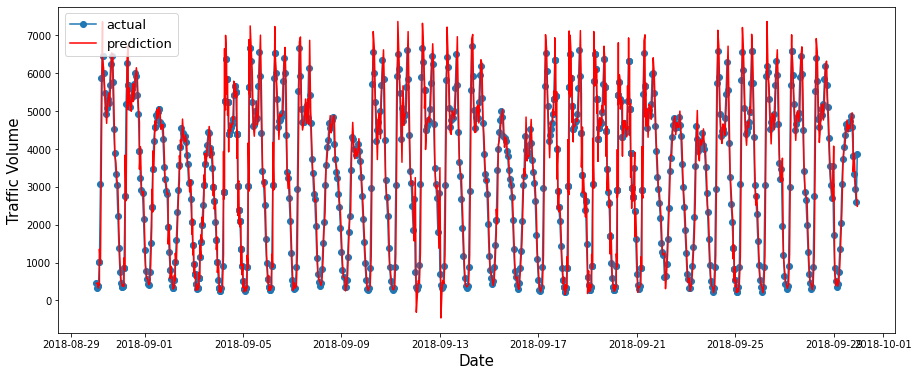

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, ts_test, marker='o', label="actual")
plt.plot(ts_test.index, Predictions, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

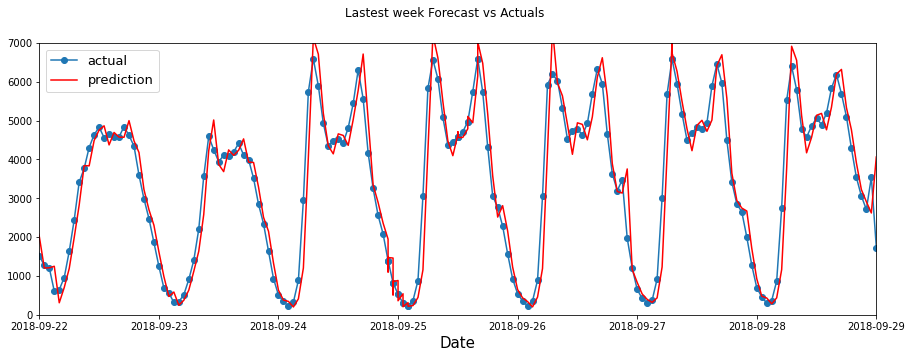

In [ ]:
# zoom on lastest week
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, ts_test, marker='o', label="actual")
plt.plot(ts_test.index, Predictions, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')